# Appliying machine learning to Datasport dataset

In this notebook we present:

* [Exploratory Statistics](#Exploratory-statistics)
* [Machine Learning-driven analysis](#ML-driven-analysis) on runners' performances 

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy import stats

import seaborn as sns
sns.set_context('notebook')
%config InlineBackend.figure_format = 'retina'

In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

## Exploratory statistics

### Loading the dataset

In [4]:
full_df = pd.read_csv('../../full_database.csv')
full_df.head(3)

,Race,Date,Distance,Name,Sex,Year,LivingPlace,Rank,Time,Delay,Pace,len_name
0,"Jungfrau-Marathon, Interlaken",sam. 06.09.2003,42.195,Abächerli Walter,M,1952,Hinwil,47,"4:31.56,1","0:53.5,3","0:6.26,0",2
1,"Jungfrau-Marathon, Interlaken",sam. 06.09.2003,42.195,Abbringh Ellen,F,1962,NL-Doorn 3941 EB,91,"5:55.9,4","2:12.11,6","0:8.25,0",2
2,"Jungfrau-Marathon, Interlaken",sam. 06.09.2003,42.195,Abegglen Eddy,M,1954,Mürren,424,"5:45.21,9","2:20.33,8","0:8.11,0",2


In [6]:
print(full_df.isnull().sum())
full_df.dtypes

Race           0
Date           0
Distance       0
Name           0
Sex            0
Year           0
LivingPlace    0
Rank           0
Time           0
Delay          0
Pace           0
len_name       0
dtype: int64


Race            object
Date            object
Distance       float64
Name            object
Sex             object
Year             int64
LivingPlace     object
Rank             int64
Time            object
Delay           object
Pace            object
len_name         int64
dtype: object

### Distribution of runners, per race  
(how popular is a race?)

In [44]:
print('number of unique races:',full_df.Race.nunique())

number of unique races: 209


In [45]:
runnerVSrace = full_df.Race.value_counts().value_counts()

In [46]:
#  just a check
sum(runnerVSrace)==full_df.Race.nunique()

True

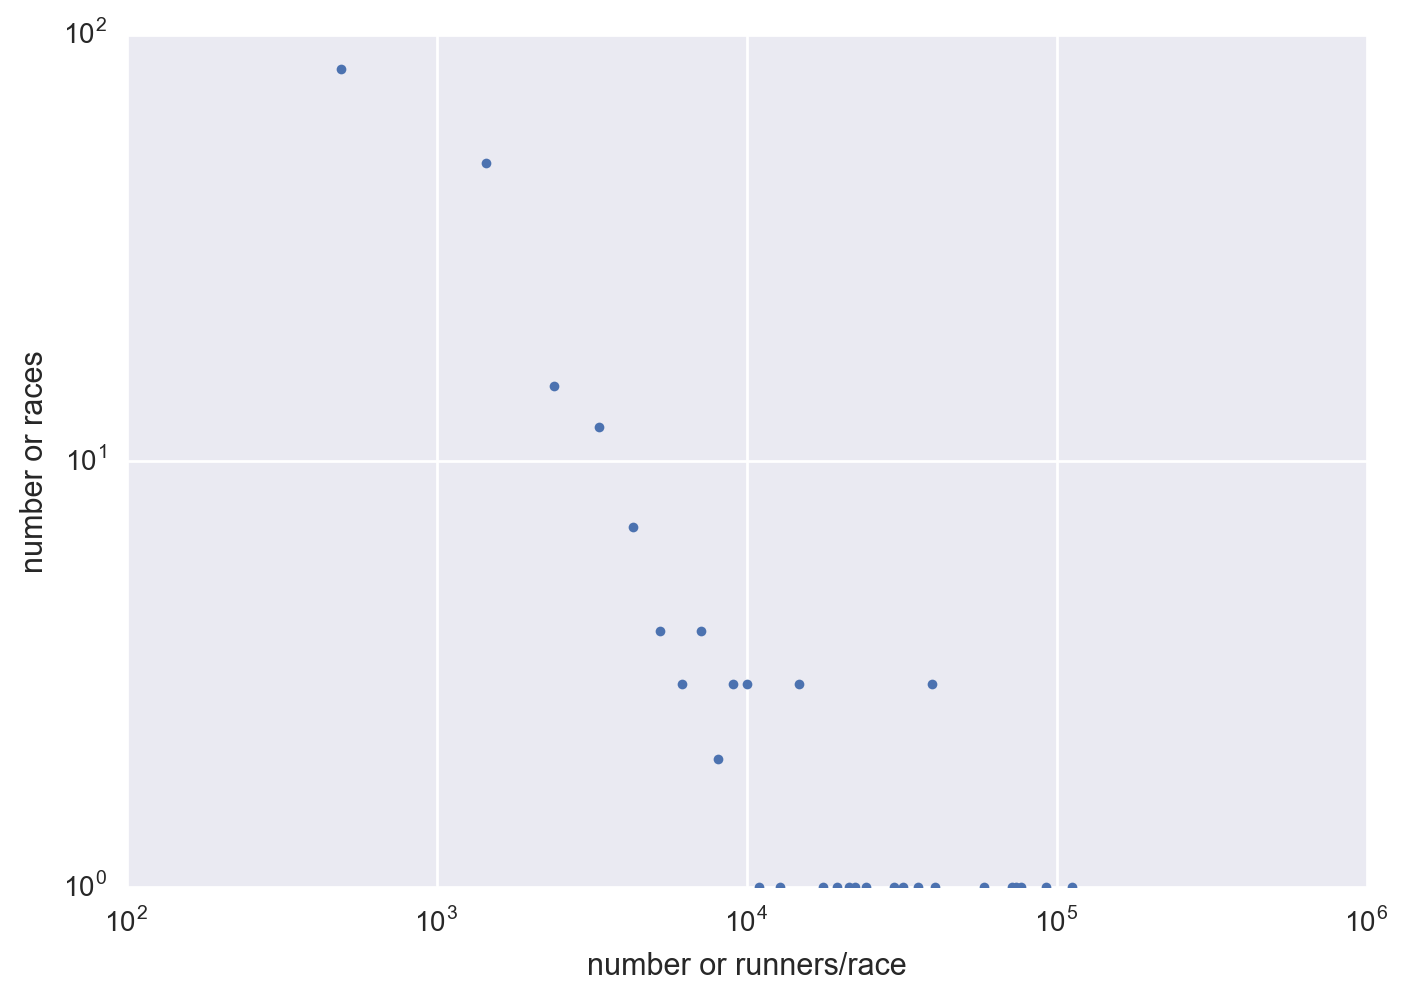

In [85]:
my_hist, bin_edges = np.histogram(full_df.Race.value_counts(),bins='fd')
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

plt.loglog(bin_centers,my_hist,marker='.',linestyle='')

plt.ylabel('number or races')
plt.xlabel('number or runners/race')

### Distribution of races, per runner
(how active is a runner?)

In [39]:
print('number of unique runners:',full_df.Name.nunique())

number of unique runners: 428644


In [40]:
raceVSrunner = full_df.Name.value_counts().value_counts()

In [41]:
sum(raceVSrunner)==full_df.Name.nunique()
# raceVSrunner

True

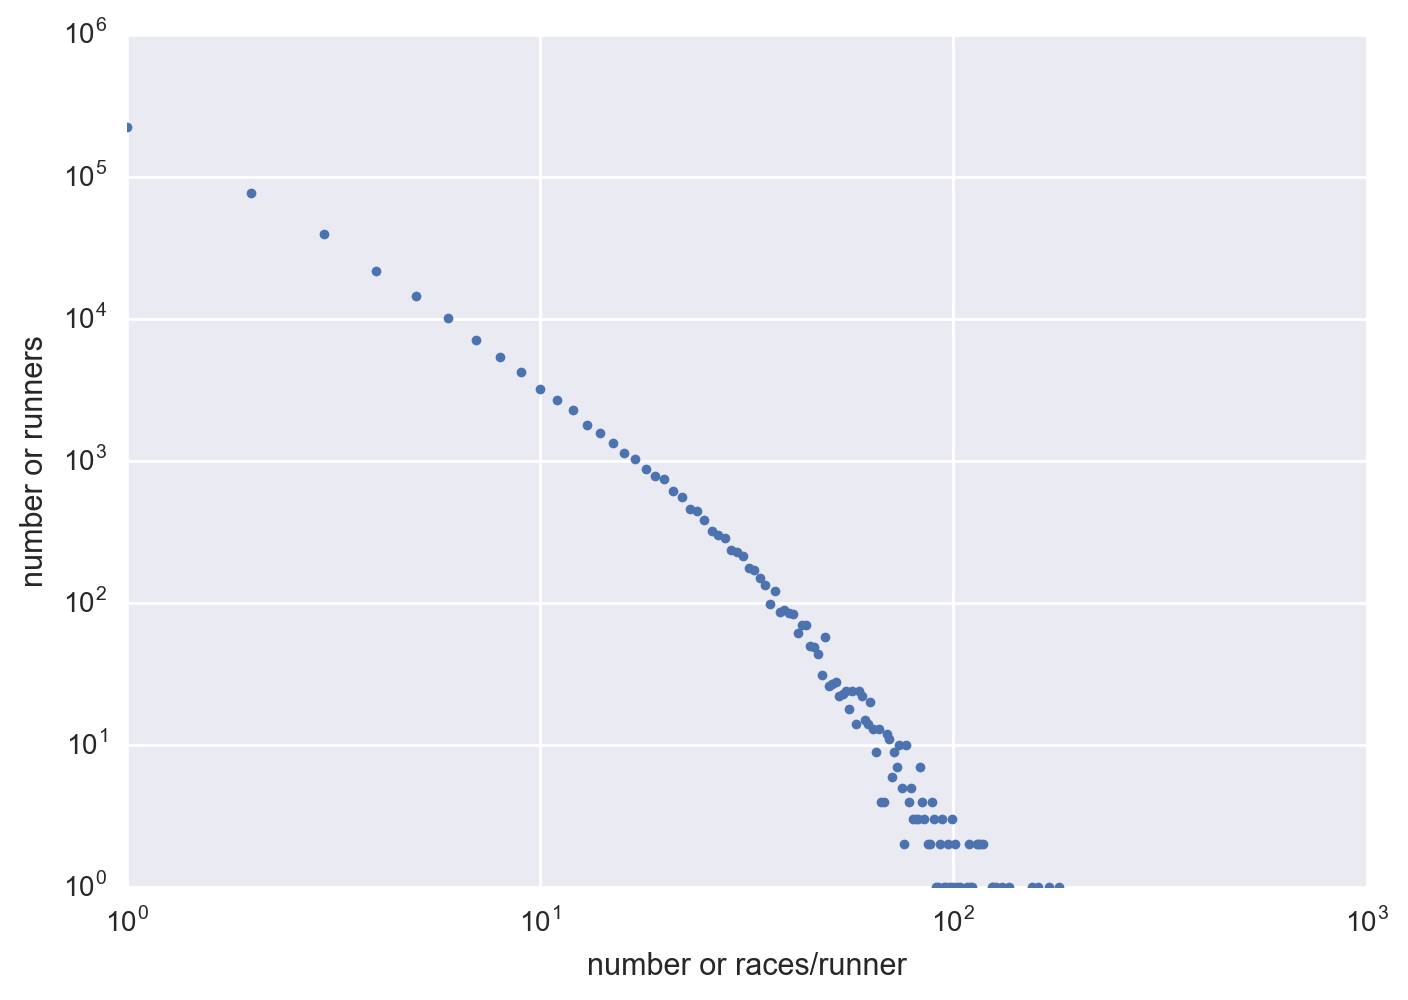

In [43]:
plt.loglog(raceVSrunner,marker='.',linestyle='')

plt.ylabel('number or runners')
plt.xlabel('number or races/runner')

### Performance VS Age  

This question has been already investigated in recent studies, on different races across the world. Here are few examples, from 
[2014(1)](http://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/2052-1847-6-31),
[2014(2)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4039284/),
[2015](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4541133/),
[2016](http://www.sciencedirect.com/science/article/pii/S2095254615000435).

All of them found a _U-shaped dependence_, for both males and females

### Performance VS Weather

One of the main study on this topic, from 
[2007](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=2007&issue=03000&article=00012&type=abstract), found correlation between 
[WBGT](https://en.wikipedia.org/wiki/Wet-bulb_globe_temperature)
and decrease of performance, both for male and female runners.  
(An older study from 
[1997](http://journals.lww.com/acsm-msse/pages/articleviewer.aspx?year=1997&issue=09000&article=00018&type=abstract)
found similar negative effects of ambient temperature on resistance in cyclists)

## ML-driven analysis

### Prediction of athletes' career progression

This article on 
[fivethirtyeight](http://fivethirtyeight.com/features/tell-us-two-things-and-well-tell-you-how-fast-youd-run-a-marathon/) 
summarises the results of a recent 
[study](https://bmcsportsscimedrehabil.biomedcentral.com/articles/10.1186/s13102-016-0052-y).
The authors improved a long-standing prective model from 
[1981](http://www.runscore.com/coursemeasurement/Articles/ARHE.pdf),
that estimates the performance (min) of an athlete on the next race, based the distance and performance on the previous one.